In [1]:
from keras.applications.xception import Xception
from keras.models import Model
from keras.applications.xception import preprocess_input, decode_predictions
from keras.layers import Input, GlobalAveragePooling2D, Dense
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

%matplotlib inline

Using TensorFlow backend.


In [2]:
def load_images(imgs_dir):
    x = []
    y = []
    
    for img_path in Path(imgs_dir).iterdir():
        img = cv2.resize(cv2.imread(str(img_path)), dsize=(128, 128))
        x.append(img)
        if img_path.name.startswith('cat'):
            y.append(False)
        else:
            y.append(True)
    
    return np.array(x, dtype=np.float32) / 255., np.array(y, dtype=np.bool)

In [3]:
def load_test_images(imgs_dir):
    ids = []
    x = []
    
    for img_path in Path(imgs_dir).iterdir():
        img = cv2.resize(cv2.imread(str(img_path)), dsize=(128, 128))
        ids.append(img_path.name[:-4])
        x.append(img)
    
    return np.array(ids), np.array(x, dtype=np.float32) / 255.

In [4]:
#示例图片
def show_img_examples(x, y):    
    inds = np.random.randint(len(y),size=12)
    x_examples = x[inds]
    y_examples = y[inds]
    fig = plt.figure(figsize=(20,8))
    for i, (img, cls) in enumerate(zip(x_examples, y_examples)):
        a = fig.add_subplot(2, 6, i+1)
        plt.imshow(img)
        a.set_title('dog {:.2f}%'.format(cls*100) if cls>0.5 else 'cat {:.2f}%'.format((1-cls)*100))
    plt.show()

In [5]:
def my_model(lr):
    
    input_tensor = Input(shape=(128, 128, 3))
    
    # create the base pre-trained model
    base_model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    
    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    # add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    
    # and a logistic layer
    predictions = Dense(1, activation='sigmoid')(x)
    
    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional Xception layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [6]:
x_train, y_train = load_images('./train_spl')

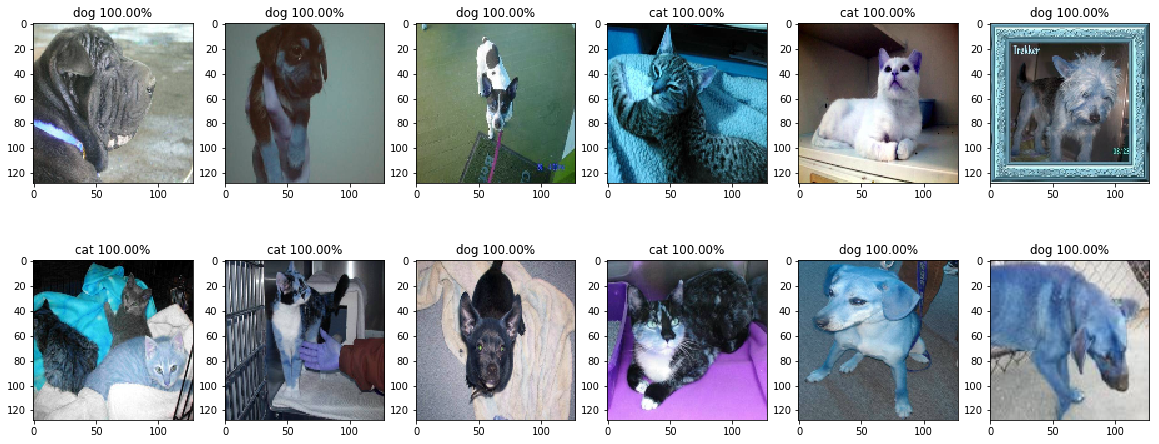

In [7]:
show_img_examples(x_train, y_train)

In [8]:
# searching params on 2000 samples
indices = np.arange(len(y_train))
np.random.shuffle(indices)
indices = indices[:200]
model = KerasClassifier(my_model, epochs=1, batch_size=64)
grid_params = {'lr':[0.0001, 0.001, 0.01]}
grid = GridSearchCV(model, grid_params, scoring='accuracy')
grid.fit(x_train[indices], y_train[indices])

Epoch 1/1
133/133 [==============================] - 22s 163ms/step - loss: 0.7158 - acc: 0.5188
Epoch 1/1
133/133 [==============================] - 72s 539ms/step - loss: 0.6775 - acc: 0.5414
Epoch 1/1
134/134 [==============================] - 30s 222ms/step - loss: 0.6721 - acc: 0.5373
Epoch 1/1
133/133 [==============================] - 92s 693ms/step - loss: 0.5874 - acc: 0.7143
Epoch 1/1
133/133 [==============================] - 60s 451ms/step - loss: 0.6162 - acc: 0.6917
Epoch 1/1
134/134 [==============================] - 148s 1s/step - loss: 0.9783 - acc: 0.5224
Epoch 1/1
133/133 [==============================] - 35s 261ms/step - loss: 2.3294 - acc: 0.5263
Epoch 1/1
133/133 [==============================] - 24s 183ms/step - loss: 0.6428 - acc: 0.6466
Epoch 1/1
134/134 [==============================] - 27s 199ms/step - loss: 2.4080 - acc: 0.5149
Epoch 1/1
200/200 [==============================] - 36s 179ms/step - loss: 0.6689 - acc: 0.5850


GridSearchCV(cv=None, error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fe1ad66de10>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'lr': [0.0001, 0.001, 0.01]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

In [9]:
# training on all training set
final_model = grid.best_estimator_.model
hist = final_model.fit(x_train, y_train, validation_split=0.2, epochs=5, batch_size=64)
final_model.save('my_model.h5')

Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 406s 254ms/step - loss: 0.4920 - acc: 0.7750 - val_loss: 0.2566 - val_acc: 0.9025
Epoch 2/5
1600/1600 [==============================] - 335s 209ms/step - loss: 0.3105 - acc: 0.8687 - val_loss: 2.1558 - val_acc: 0.6875
Epoch 3/5
1600/1600 [==============================] - 341s 213ms/step - loss: 0.2415 - acc: 0.9050 - val_loss: 1.3309 - val_acc: 0.7750
Epoch 4/5
1600/1600 [==============================] - 341s 213ms/step - loss: 0.2140 - acc: 0.9113 - val_loss: 2.5560 - val_acc: 0.6750
Epoch 5/5
1600/1600 [==============================] - 343s 214ms/step - loss: 0.1509 - acc: 0.9413 - val_loss: 3.0980 - val_acc: 0.6550


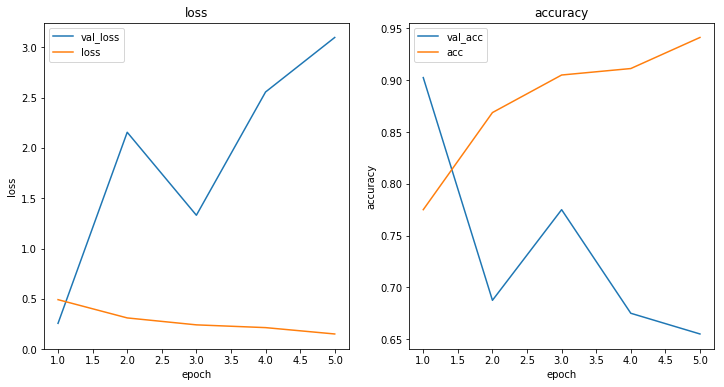

In [11]:
his = hist.history
epochs = list(range(1, 6))
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title('loss')
plt.plot(epochs, his['val_loss'], label='val_loss')
plt.plot(epochs, his['loss'], label='loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(122)
plt.title('accuracy')
plt.plot(epochs, his['val_acc'], label='val_acc')
plt.plot(epochs, his['acc'], label='acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

plt.show()

In [12]:
ids, x_test = load_test_images('./test_spl')

preds = final_model.predict(x_test)

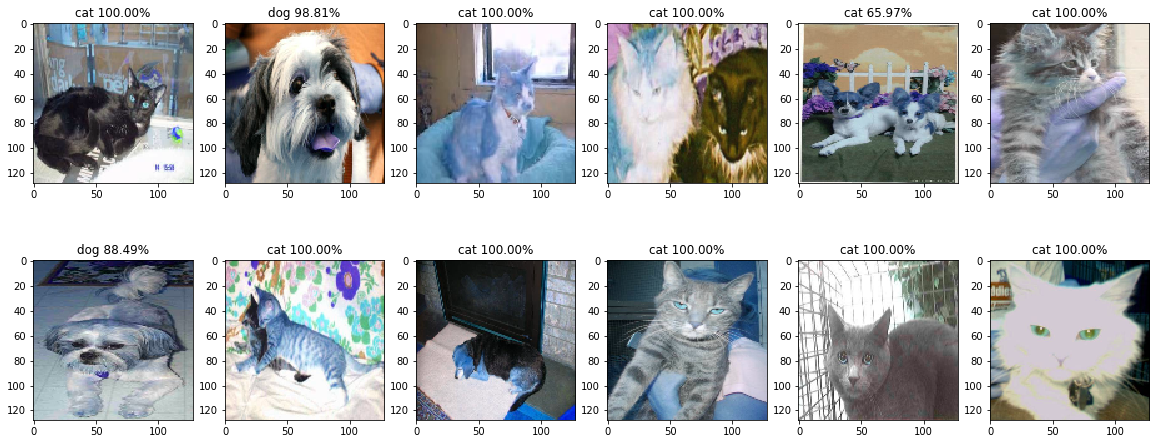

In [13]:
show_img_examples(x_test, preds[:,0])

In [14]:
# save predictions as a csv file
import pandas as pd
dic = {'id':ids, 'label':list(map(lambda x:'{:.4f}'.format(x), preds.flatten()))}
df = pd.DataFrame(dic)
df.to_csv('submission.csv', index=False)